In [1]:
import torchvision
import torch
import numpy as np
import torchvision.transforms as transforms
import tqdm
from torch.autograd import Variable
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
import uuid

In [2]:
data_path = './Data/'

In [4]:
trans = ([transforms.ToTensor()])
trans = transforms.Compose(trans)
fulltrainset = torchvision.datasets.MNIST(root=data_path, train=True, download=True, transform=trans)
trainloader = torch.utils.data.DataLoader(fulltrainset, batch_size=2000, shuffle=False, num_workers=2, pin_memory=True)
test_set = torchvision.datasets.MNIST(root=data_path, train=False, download=True, transform=trans)
testloader = torch.utils.data.DataLoader(test_set, batch_size=2000, shuffle=False, num_workers=2, pin_memory=True)
nb_classes = 10

## 1.1 Fixed Color Code Generator

In [6]:
def get_fixed_color_codes(nb_classes):
    np.random.seed(0)  # Ensure reproducibility
    return np.array([[np.random.uniform(0, 1) for _ in range(3)] for _ in range(nb_classes)])

# Updated `gen_fgbgcolor_data` function
def gen_fgbgcolor_data(loader, img_size=(3,28,28), nb_classes=10, noise=10.):
    # Generate unique colors for each class
    Cfg = get_fixed_color_codes(nb_classes)
    Cbg = get_fixed_color_codes(nb_classes)  # If background color is required

    tot_iters = len(loader)
    for i in tqdm.tqdm(range(tot_iters), total=tot_iters):
        x, targets = next(iter(loader))
        assert len(x.size()) == 4, 'Input x should be 4-dimensional (B x C x H x W)'
        targets = targets.cpu().numpy()
        bs = targets.shape[0]

        x = (((x * 255) > 150) * 255).type(torch.FloatTensor)
        x_rgb = torch.ones(x.size(0), 3, x.size()[2], x.size()[3]).type(torch.FloatTensor) * x
        x_rgb_fg = x_rgb.clone()

        # Assign unique colors to each class
        c = Cfg[targets]
        c = c.reshape(-1, 3, 1, 1)
        c = torch.from_numpy(c).type(torch.FloatTensor)

        x_rgb_fg[:, 0] = x_rgb_fg[:, 0] * c[:, 0]
        x_rgb_fg[:, 1] = x_rgb_fg[:, 1] * c[:, 1]
        x_rgb_fg[:, 2] = x_rgb_fg[:, 2] * c[:, 2]

        x_rgb = x_rgb_fg + torch.tensor(noise * np.random.randn(*x_rgb.size())).type(torch.FloatTensor)
        x_rgb = torch.clamp(x_rgb, 0., 255.)

        if i == 0:
            color_data_x = np.zeros((bs * tot_iters, *img_size))
            color_data_y = np.zeros((bs * tot_iters,))
        color_data_x[i * bs: (i + 1) * bs] = x_rgb / 255.
        color_data_y[i * bs: (i + 1) * bs] = targets
    return color_data_x, color_data_y

# Directory setup
dir_name = data_path + 'cmnist/' + 'fgbg_cmnist_cpr_fixed_colors/'
print(dir_name)
if not os.path.exists(data_path + 'cmnist/'):
    os.mkdir(data_path + 'cmnist/')
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

# Generate and save data
nb_classes = 10  # Number of unique classes
color_data_x, color_data_y = gen_fgbgcolor_data(testloader, img_size=(3, 28, 28), nb_classes=nb_classes, noise=10.)
np.save(dir_name + '/test_x.npy', color_data_x)
np.save(dir_name + '/test_y.npy', color_data_y)

./Data/cmnist/fgbg_cmnist_cpr_fixed_colors/


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


## 1.2 Random Color Code Generator

In [46]:
# generate color codes
def get_color_codes(cpr):
    C = np.random.rand(len(cpr), nb_classes,3)
    C = C/np.max(C, axis=2)[:,:,None]
    print(C.shape)
    return C

def gen_fgbgcolor_data(loader, img_size=(3,28,28), cpr=[0.5, 0.5], noise=10.):
    if cpr is not None:
        assert sum(cpr)==1, '--cpr must be a non-negative list which sums to 1'
        Cfg = get_color_codes(cpr)
        Cbg = get_color_codes(cpr)
    else:
        Cfg = get_color_codes([1])
        Cbg = get_color_codes([1])
    tot_iters =  len(loader)
    for i in tqdm.tqdm(range(tot_iters), total=tot_iters):
        x, targets = next(iter(loader))
        assert len(x.size())==4, 'Something is wrong, size of input x should be 4 dimensional (B x C x H x W; perhaps number of channels is degenrate? If so, it should be 1)'
        targets = targets.cpu().numpy()
        bs = targets.shape[0]

        x = (((x*255)>150)*255).type('torch.FloatTensor')
        x_rgb = torch.ones(x.size(0),3, x.size()[2], x.size()[3]).type('torch.FloatTensor')
        x_rgb = x_rgb* x
        x_rgb_fg = 1.*x_rgb
        
        color_choice = np.argmax(np.random.multinomial(1, cpr, targets.shape[0]), axis=1) if cpr is not None else 0
        c = Cfg[color_choice,targets] if cpr is not None else Cfg[color_choice,np.random.randint(nb_classes, size=targets.shape[0])]
        c = c.reshape(-1, 3, 1, 1)
        c= torch.from_numpy(c).type('torch.FloatTensor')
        x_rgb_fg[:,0] = x_rgb_fg[:,0]* c[:,0]
        x_rgb_fg[:,1] = x_rgb_fg[:,1]* c[:,1]
        x_rgb_fg[:,2] = x_rgb_fg[:,2]* c[:,2]
        
        # bg = (255-x_rgb)
        # # c = C[targets] if np.random.rand()>cpr else C[np.random.randint(C.shape[0], size=targets.shape[0])]
        # color_choice = np.argmax(np.random.multinomial(1, cpr, targets.shape[0]), axis=1) if cpr is not None else 0
        # c = Cbg[color_choice,targets] if cpr is not None else Cbg[color_choice,np.random.randint(nb_classes, size=targets.shape[0])]
        # c = c.reshape(-1, 3, 1, 1)
        # c= torch.from_numpy(c).type('torch.FloatTensor')
        # bg[:,0] = bg[:,0]* c[:,0]
        # bg[:,1] = bg[:,1]* c[:,1]
        # bg[:,2] = bg[:,2]* c[:,2]
        # x_rgb = x_rgb_fg + bg

        x_rgb = x_rgb_fg
        
        x_rgb = x_rgb + torch.tensor((noise)* np.random.randn(*x_rgb.size())).type('torch.FloatTensor')
        x_rgb = torch.clamp(x_rgb, 0.,255.)
        if i==0:
            color_data_x = np.zeros((bs* tot_iters, *img_size))
            color_data_y = np.zeros((bs* tot_iters,))
        color_data_x[i*bs: (i+1)*bs] = x_rgb/255.
        color_data_y[i*bs: (i+1)*bs] = targets
    return color_data_x, color_data_y

dir_name = data_path + 'cmnist/' + 'fgbg_cmnist_cpr' + '-'.join(str(p) for p in [0.5, 0.5]) + '/'
print(dir_name)
if not os.path.exists(data_path + 'cmnist/'):
    os.mkdir(data_path + 'cmnist/')
if not os.path.exists(dir_name):
    os.mkdir(dir_name)


color_data_x, color_data_y = gen_fgbgcolor_data(trainloader, img_size=(3,28,28), noise=10.)
np.save(dir_name+ '/train_x.npy', color_data_x)
np.save(dir_name+ '/train_y.npy', color_data_y)


./Data/cmnist/fgbg_cmnist_cpr0.5-0.5/
(2, 10, 3)
(2, 10, 3)


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


In [49]:
color_data_x, color_data_y = gen_fgbgcolor_data(testloader, img_size=(3,28,28), noise=10.)
np.save(dir_name+ '/test_x.npy', color_data_x)
np.save(dir_name+ '/test_y.npy', color_data_y)

(2, 10, 3)
(2, 10, 3)


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


In [5]:
train_x = np.load('./Data/cmnist/fgbg_cmnist_cpr_fixed_colors/train_x.npy')
train_y = np.load('./Data/cmnist/fgbg_cmnist_cpr_fixed_colors/train_y.npy')

Displaying a batch of images:


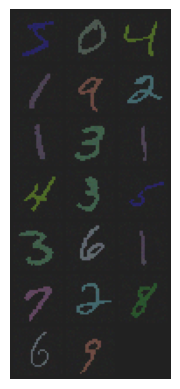

Labels: [5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0, 1.0, 4.0, 3.0, 5.0, 3.0, 6.0, 1.0, 7.0]


In [7]:
# Function to unnormalize and display an image
def imshow(img):
    # Unnormalize the image
    img = img * 0.3081 + 0.1307  # Reverse normalization
    npimg = img.numpy()  # Convert tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change dimensions for pyplot (HWC format)
    plt.axis('off')  # Hide axes
    plt.show()


images, labels = train_x[:20], train_y[:20]

# Convert images to tensors if needed (should already be tensors from DataLoader)
if not isinstance(images, torch.Tensor):
    images = torch.tensor(images)

# Display images in a grid
print('Displaying a batch of images:')
imshow(torchvision.utils.make_grid(images, nrow=3))  # Show 8 images per row

# Print corresponding labels
print('Labels:', labels[:16].tolist())  # Print labels for the first 16 images


## 1.3 Saving the numpy files as RGB Images

In [8]:
def save_image(images, labels, split_name):
    for idx, (img, label) in enumerate(zip(images, labels)):
        img = (img * 0.3081 + 0.1307)*255
        # img = img.numpy()
        img = np.transpose(img, (1, 2, 0))
        # print(label)
        dst_path = split_name + "/" + str(int(label)) + "/"
        os.makedirs(dst_path, exist_ok=True)
        dst_path = dst_path + str(uuid.uuid4()) + ".jpg"
        print("saving {0}".format(dst_path))
        cv2.imwrite(dst_path, img)

In [9]:
images = np.load('./Data/cmnist/fgbg_cmnist_cpr_fixed_colors/test_x.npy')
labels = np.load('./Data/cmnist/fgbg_cmnist_cpr_fixed_colors/test_y.npy')

In [ ]:
save_image(images, labels, "test")

saving test/7/d5e8ad96-320c-43a6-82d3-d57e434b3aa9.jpg
saving test/2/dd88c471-be0b-470b-ac36-4c1f34a3cffa.jpg
saving test/1/dd912f64-2e7f-4739-b4b3-568fd3619522.jpg
saving test/0/f2b20b63-3e8f-4893-b29d-daec7c6b438e.jpg
saving test/4/bfb86fda-60b5-4e38-9bbe-8a04243013e1.jpg
saving test/1/42462c02-17fa-4034-919e-07d27ec9c014.jpg
saving test/4/9adda01c-d930-41d1-b0b9-37640262bcc8.jpg
saving test/9/fa8c0d7a-da33-40fe-9ffa-4164fcb0a749.jpg
saving test/5/dddf6d3a-d9fc-4595-91ed-682761c8003b.jpg
saving test/9/4ea03b94-7934-45de-867d-a1417239220d.jpg
saving test/0/4dcd8223-9d55-4d04-843f-f75535f8b728.jpg
saving test/6/53c090df-e2fe-4c96-86e6-c0101fc7c480.jpg
saving test/9/24e2f88f-5ebc-4349-900b-03bd9be53353.jpg
saving test/0/1e9e7470-7c54-4274-8b92-bbc87b7b4055.jpg
saving test/1/d86785cc-abdb-4424-95aa-74cd0e0c1717.jpg
saving test/5/c2f0cd9f-00d1-435c-9868-43d78792965b.jpg
saving test/9/4570f208-fb15-4bb9-9a95-d359b4d8d8b4.jpg
saving test/7/dffeeaae-1419-4e12-bbcf-30b2e4fcc1ef.jpg
saving tes